In [4]:
# Code goal: Perform sensitivity analysis for a simple reliability problem with two variables. 
# Author: Haochen Ye (hxy46@psu.edu)
#-----------------
# Details: Sobol method and Morris method are included using "sensitivity" package.
#         For Sobol analysis, random Monte Carlo (MC), Latin Hypercube Sampling (LHS) and Sobol 
#         sequence sampling methods are included.

# remove all existing variables and plots
rm(list = ls())
graphics.off()
# load the required libraries
library(sensitivity)
library(lhs) #Generate Latin Hypercube samples
library(randtoolbox) #Generate Sobol sequence (Quasi MC)

Warning message:
"package 'sensitivity' was built under R version 3.6.3"Warning message:
"package 'lhs' was built under R version 3.6.3"Warning message:
"package 'randtoolbox' was built under R version 3.6.2"Loading required package: rngWELL
Warning message:
"package 'rngWELL' was built under R version 3.6.2"This is randtoolbox. For an overview, type 'help("randtoolbox")'.

Attaching package: 'randtoolbox'

The following object is masked from 'package:sensitivity':

    sobol



In [5]:
# Problem definition:  
# A reliability problem: return yes (1) if the product of two numbers >=0.75
#                       return no (0) otherwise
# Both input samples are distributed uniformly in [0,1]
Reliability<-function (X) {
  floor(X[ ,1]*X[ ,2]/0.75)
}

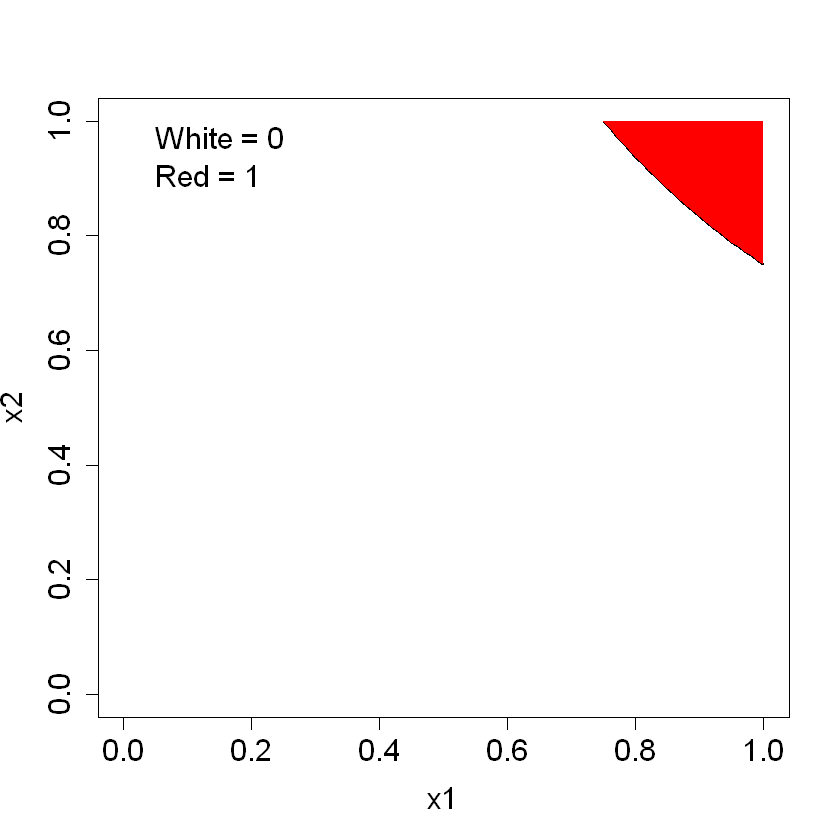

In [5]:
# Plot the response surface of the problem
x <- seq(0.75,1,by=0.01)
plot(x,0.75/x,type="l",lwd=2,xlim=c(0,1),ylim=c(0,1),xlab="x1",ylab="x2",cex.lab=1.5,cex.axis=1.5)
polygon(c(0.75,1,rev(x)),c(1,1,rev(0.75/x)),col="red",border = NA)
legend("topleft",legend = c("White = 0", 'Red = 1'),cex = 1.5,bty = "n")

In [6]:
#Simple test with 1000 samples
X <- data.frame(matrix(runif(2*1000), nrow = 1000))
X$Y <- Reliability(X)
#Mean value of Y approximates the area of the red region
mean(X$Y)

[1] 0.039

In [7]:
# Then we perform an ANOVA (Analysis of Variance) test
# ANOVA requires a factor definition for each input, and a near normal distribution within each factor.
# Thus theoretically ANOVA does not work for this binary reliability problem.
# We modify the output to be the product of X1X2
X$Y<-X$X1*X$X2
# And we define 10 equal factor levels for X1 and X2 (0~0.1,0.1~0.2 ...)
X$X1<-as.factor(floor(10*X$X1))
X$X2<-as.factor(floor(10*X$X2))
ANOVA <- aov(Y ~ X1*X2, data = X)
summary(ANOVA)
# Due to symmetry of X1 and X2, they should have the same importance, but we see this simple
#   ANOVA test show slightly different results for them (due to limited sample size). 
# Based on the p-value, the result concludes that both X1 and X2 are important. 
#   Their interaction term is important as well. This general conclusion is consistent 
#   with our expectation.

             Df Sum Sq Mean Sq F value Pr(>F)    
X1            9 23.343  2.5936  4314.4 <2e-16 ***
X2            9 21.660  2.4067  4003.4 <2e-16 ***
X1:X2        81  6.660  0.0822   136.8 <2e-16 ***
Residuals   900  0.541  0.0006                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [8]:
# Sobol analysis

# Base sample size (note it needs two samples of equal size in "sensitivity" package)
# The actual total number of model evaluation is dependent on the exact function (estimator) to use.
# For sobol() function, total cost is (N+1)*n = 3n (N is the number of input parameters, here is 2)
n <- 50000

# Three sampling choices: choose one to run
choice <- 1 # 1 or 2 or 3

#1. Random MC
if (choice == 1){
  X1 <- data.frame(matrix(runif(2*n), nrow = n))
  X2 <- data.frame(matrix(runif(2*n), nrow = n))
}

#2. Quasi MC -- Sobol sequence
if (choice == 2){
  X <- data.frame(randtoolbox::sobol(n = 2*n, dim = 2))
  #Randomly divide into two samples
  ind <- sample(c(rep(TRUE,n), rep(FALSE,n)), replace=FALSE)
  X1 <- X[ind, ]
  X2 <- X[!ind, ]
}

#3. Latin Hypercube sampling
if (choice == 3){
  X <- data.frame(randomLHS(2*n,2))
  #Randomly divide into two samples
  ind <- sample(c(rep(TRUE,n), rep(FALSE,n)), replace=FALSE)
  X1 <- X[ind, ]
  X2 <- X[!ind, ]
}

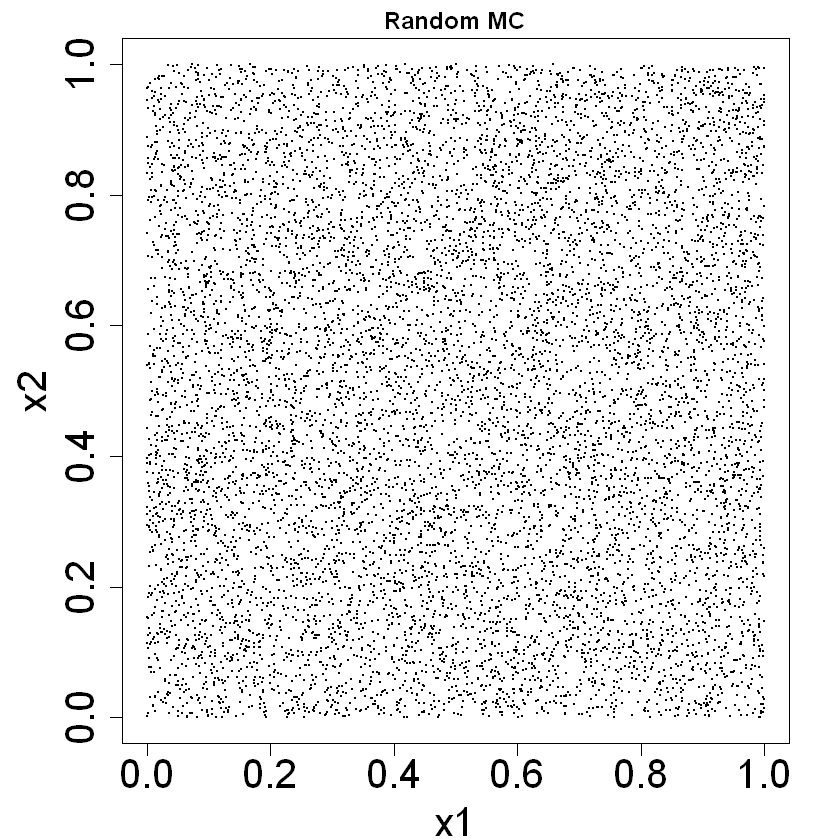

In [28]:
# Plot the scatter plot of the samples (only take first 10000 samples)
par(mar=c(4,5.1,1.6,2.1))
plot(X1$X1[1:10000],X1$X2[1:10000],pch=19,cex=0.1,xlim=c(0,1),ylim=c(0,1),xlab="x1",ylab="x2",cex.lab=2,cex.axis=2)
# Note to change the title based on selected sampling method.
if (choice == 1)
  text <- "Random MC"
if (choice == 2)
  text <- "Sobol sequence"
if (choice == 3)
  text <- "LHS"
title(main = text,cex=2)

In [9]:
# Calculate Sobol sensitivity index under different base sample sizes.
# Set 100 calculations (every 1000 samples)
# S1 and S2 are first-order indices, S3 is second-order index.
S1 <- S2 <- S3 <- rep(NA,100)
S1_up <- S2_up <- S3_up <- rep(NA,100)
S1_low <- S2_low <- S3_low <- rep(NA,100)
for (i in 1:100){
  S<-sensitivity::sobol(model = Reliability, X1 = X1[1:(n/100*i), ], X2 = X2[1:(n/100*i), ],
                        order=2, nboot = 100)
  S1[i]<-S$S$original[1]
  S2[i]<-S$S$original[2]
  S3[i]<-S$S$original[3]
  S1_up[i]<-S$S$`max. c.i.`[1]
  S2_up[i]<-S$S$`max. c.i.`[2]
  S3_up[i]<-S$S$`max. c.i.`[3]
  S1_low[i]<-S$S$`min. c.i.`[1]
  S2_low[i]<-S$S$`min. c.i.`[2]
  S3_low[i]<-S$S$`min. c.i.`[3]
}

In [6]:
# Calculate the theoretical value of first-order Sobol sensitivity index as reference
# Due to the symmetry of the problem definition, both input parameters must have the same
#     first-order sensitivity indices.
#-------------
# This value is given by the variance decomposition: Var(E[y|x1])/Var(y) (Sobol, 1993)

# Step 1: calculate Var(y):
# Var(y) = E[(y-E[y])^2]
# Denote u = E[y] for convenience. Obviously the ratio of y=1 and y=0 in the entire response
#     surface is u:(1-u)
# u = area of the red region of the response surface = int(1-0.75/x)dx|x~[0.75,1]
#     where int() represents the integral.
u <- 0.25-0.75*(log(1)-log(0.75))
# Var(y) = (1-u)*(0-u)^2 + u*(1-u)^2  Here each term represents when y=0 and when y=1
V <- (1-u)*(0-u)^2 + u*(1-u)^2 

# Step 2: calculate Var(E[y|x1])
# Denote E[y|x1] = f(x1), u1 = E[f(x1)] for convenience
# f(x1) = 0            if 0    <= x1 <= 0.75
# f(x1) = 1-0.75/x     if 0.75 <= x1 <= 1
# u1 = u obviously, then Var(f(x1)) = E[(f(x1)-u)^2]
# Var(f(x1)) = 0.75*(0-u)^2 + int[(1-0.75/x-u)^2]dx|x~[0.75,1]
#            = 0.75*u^2 + int[(1-u)^2 - 1.5*(1-u)/x + (0.75/x)^2]dx|x~[0.75,1]
#            = 0.75*u^2 + 0.25*(1-u)^2 - 1.5*(1-u)*(log(1)-log(0.75)) + 0.75^2*(-1+1/0.75)
V1 <- 0.75*u^2 + 0.25*(1-u)^2 - 1.5*(1-u)*(log(1)-log(0.75)) + 0.75^2*(-1+1/0.75)
S_theoretical <- V1/V
S_theoretical

[1] 0.1453032

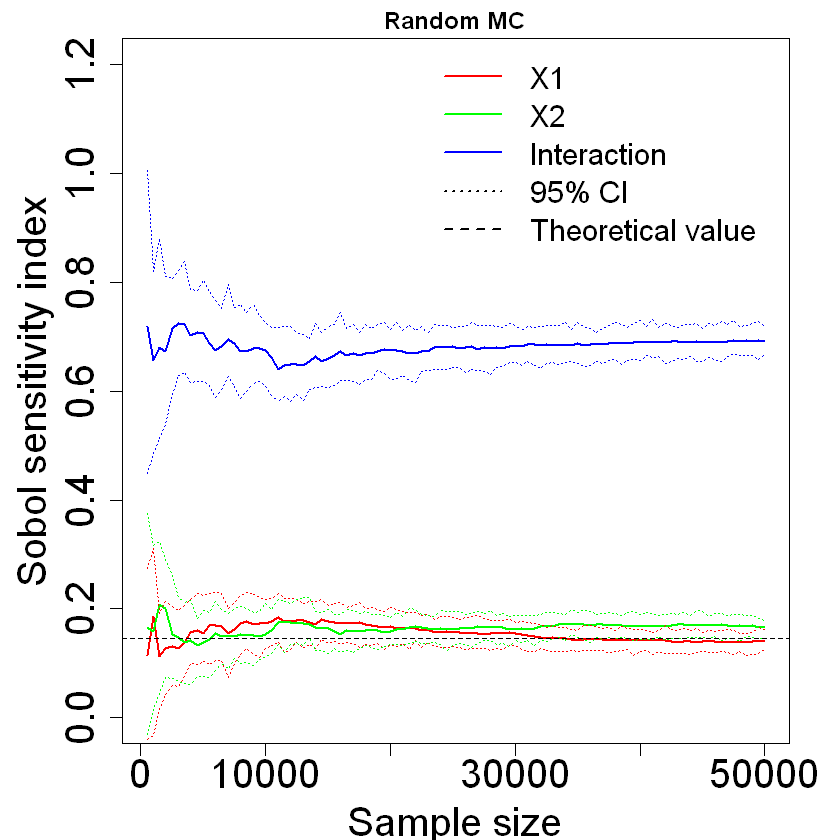

In [12]:
# Plot Sobol sensitivity index
par(mar=c(4,5.1,1.6,2.1))
plot(seq(n/100,n,by=n/100),S1,type="l",lwd=2,xlab="Sample size",ylab="Sobol sensitivity index",
     cex.lab=2,cex.axis=2,ylim=c(0,1.2),col="red")
lines(seq(n/100,n,by=n/100),S2,lwd=2,col="green")
lines(seq(n/100,n,by=n/100),S3,lwd=2,col="blue")
lines(seq(n/100,n,by=n/100),S1_up,lwd=1,lty=3,col="red")
lines(seq(n/100,n,by=n/100),S2_up,lwd=1,lty=3,col="green")
lines(seq(n/100,n,by=n/100),S3_up,lwd=1,lty=3,col="blue")
lines(seq(n/100,n,by=n/100),S1_low,lwd=1,lty=3,col="red")
lines(seq(n/100,n,by=n/100),S2_low,lwd=1,lty=3,col="green")
lines(seq(n/100,n,by=n/100),S3_low,lwd=1,lty=3,col="blue")
abline(h=S_theoretical,lty=2) # theoretical value of S1 and S2
legend("topright",lwd=c(2,2,2,2,2),lty=c(1,1,1,3,2),col = c("red","green","blue","black","black"),
       legend = c("X1","X2","Interaction","95% CI","Theoretical value"),cex=1.5,bty="n")
if (choice == 1)
  text <- "Random MC"
if (choice == 2)
  text <- "Sobol sequence"
if (choice == 3)
  text <- "LHS"
title(main = text,cex=2)


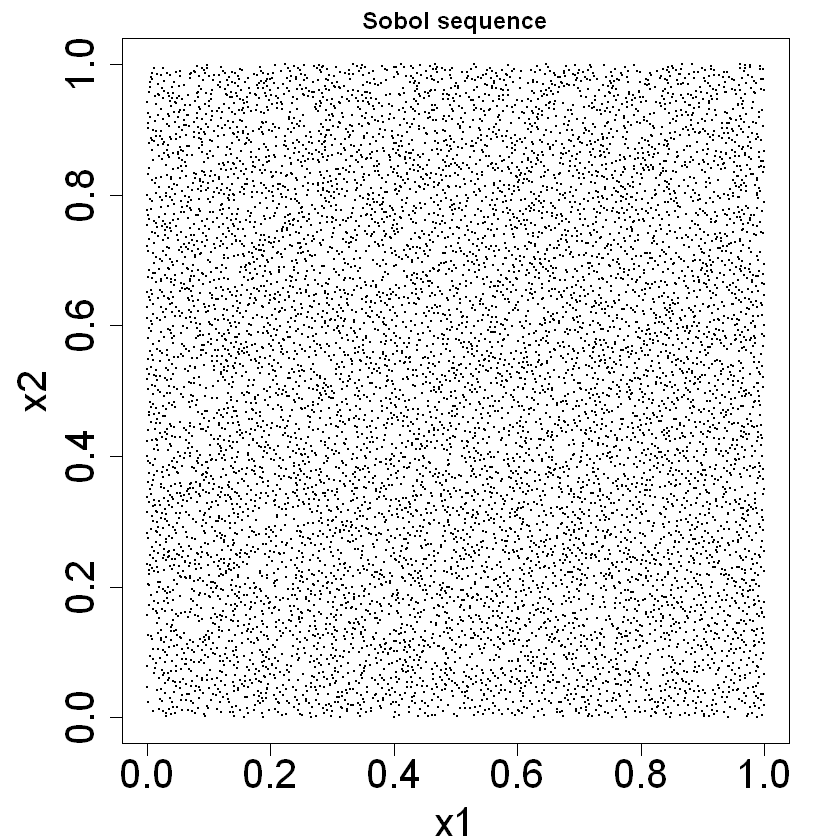

In [7]:
# Sobol analysis

# Base sample size (note it needs two samples of equal size in "sensitivity" package)
# The actual total number of model evaluation is dependent on the exact function (estimator) to use.
# For sobol() function, total cost is (N+1)*n = 3n (N is the number of input parameters, here is 2)
n <- 50000
X <- data.frame(randtoolbox::sobol(n = 2*n, dim = 2))
#Randomly divide into two samples
ind <- sample(c(rep(TRUE,n), rep(FALSE,n)), replace=FALSE)
X1 <- X[ind, ]
X2 <- X[!ind, ]

# Plot the scatter plot of the samples (only take first 10000 samples)
par(mar=c(4,5.1,1.6,2.1))
plot(X1$X1[1:10000],X1$X2[1:10000],pch=19,cex=0.1,xlim=c(0,1),ylim=c(0,1),xlab="x1",ylab="x2",cex.lab=2,cex.axis=2)
# Note to change the title based on selected sampling method.
text <- "Sobol sequence"
title(main = text,cex=2)

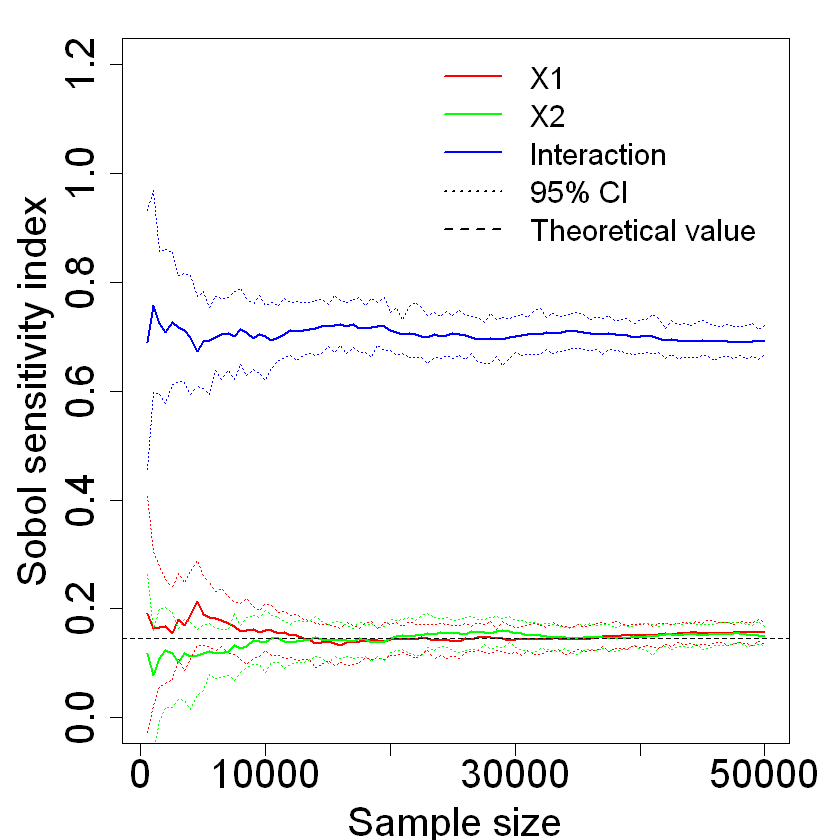

In [10]:
# Calculate Sobol sensitivity index under different base sample sizes.
# Set 100 calculations (every 1000 samples)
# S1 and S2 are first-order indices, S3 is second-order index.
S1 <- S2 <- S3 <- rep(NA,100)
S1_up <- S2_up <- S3_up <- rep(NA,100)
S1_low <- S2_low <- S3_low <- rep(NA,100)
for (i in 1:100){
  S<-sensitivity::sobol(model = Reliability, X1 = X1[1:(n/100*i), ], X2 = X2[1:(n/100*i), ],
                        order=2, nboot = 100)
  S1[i]<-S$S$original[1]
  S2[i]<-S$S$original[2]
  S3[i]<-S$S$original[3]
  S1_up[i]<-S$S$`max. c.i.`[1]
  S2_up[i]<-S$S$`max. c.i.`[2]
  S3_up[i]<-S$S$`max. c.i.`[3]
  S1_low[i]<-S$S$`min. c.i.`[1]
  S2_low[i]<-S$S$`min. c.i.`[2]
  S3_low[i]<-S$S$`min. c.i.`[3]
}
# Plot Sobol sensitivity index
par(mar=c(4,5.1,1.6,2.1))
plot(seq(n/100,n,by=n/100),S1,type="l",lwd=2,xlab="Sample size",ylab="Sobol sensitivity index",
     cex.lab=2,cex.axis=2,ylim=c(0,1.2),col="red")
lines(seq(n/100,n,by=n/100),S2,lwd=2,col="green")
lines(seq(n/100,n,by=n/100),S3,lwd=2,col="blue")
lines(seq(n/100,n,by=n/100),S1_up,lwd=1,lty=3,col="red")
lines(seq(n/100,n,by=n/100),S2_up,lwd=1,lty=3,col="green")
lines(seq(n/100,n,by=n/100),S3_up,lwd=1,lty=3,col="blue")
lines(seq(n/100,n,by=n/100),S1_low,lwd=1,lty=3,col="red")
lines(seq(n/100,n,by=n/100),S2_low,lwd=1,lty=3,col="green")
lines(seq(n/100,n,by=n/100),S3_low,lwd=1,lty=3,col="blue")
abline(h=S_theoretical,lty=2) # theoretical value of S1 and S2
legend("topright",lwd=c(2,2,2,2,2),lty=c(1,1,1,3,2),col = c("red","green","blue","black","black"),
       legend = c("X1","X2","Interaction","95% CI","Theoretical value"),cex=1.5,bty="n")


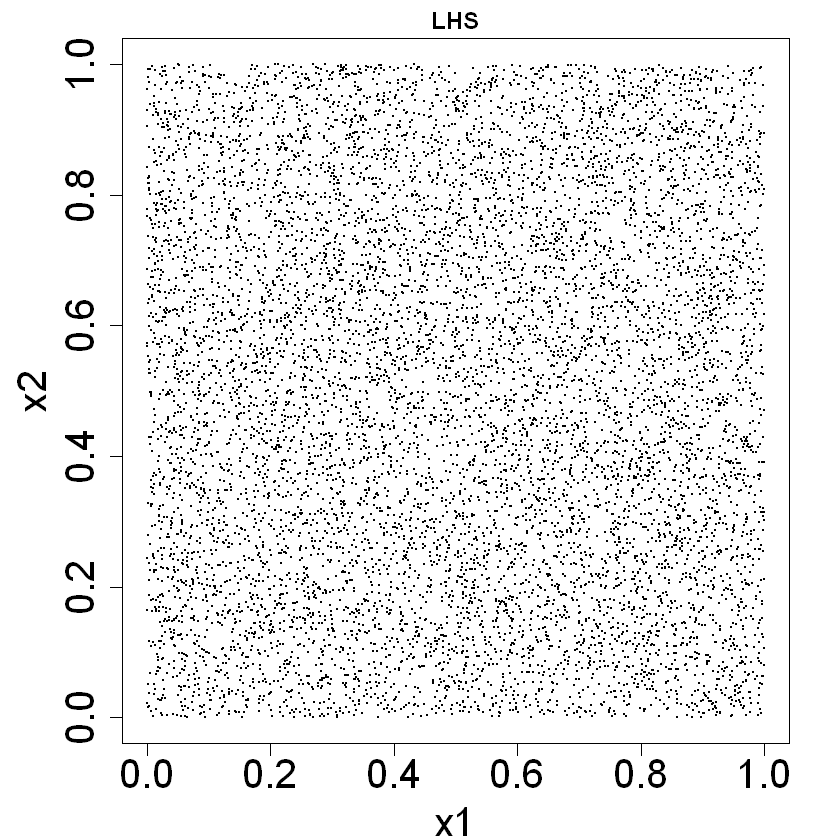

In [11]:
# Base sample size (note it needs two samples of equal size in "sensitivity" package)
# The actual total number of model evaluation is dependent on the exact function (estimator) to use.
# For sobol() function, total cost is (N+1)*n = 3n (N is the number of input parameters, here is 2)
n <- 50000
#3. Latin Hypercube sampling
X <- data.frame(randomLHS(2*n,2))
#Randomly divide into two samples
ind <- sample(c(rep(TRUE,n), rep(FALSE,n)), replace=FALSE)
X1 <- X[ind, ]
X2 <- X[!ind, ]

# Plot the scatter plot of the samples (only take first 10000 samples)
par(mar=c(4,5.1,1.6,2.1))
plot(X1$X1[1:10000],X1$X2[1:10000],pch=19,cex=0.1,xlim=c(0,1),ylim=c(0,1),xlab="x1",ylab="x2",cex.lab=2,cex.axis=2)
# Note to change the title based on selected sampling method.
text <- "LHS"
title(main = text,cex=2)

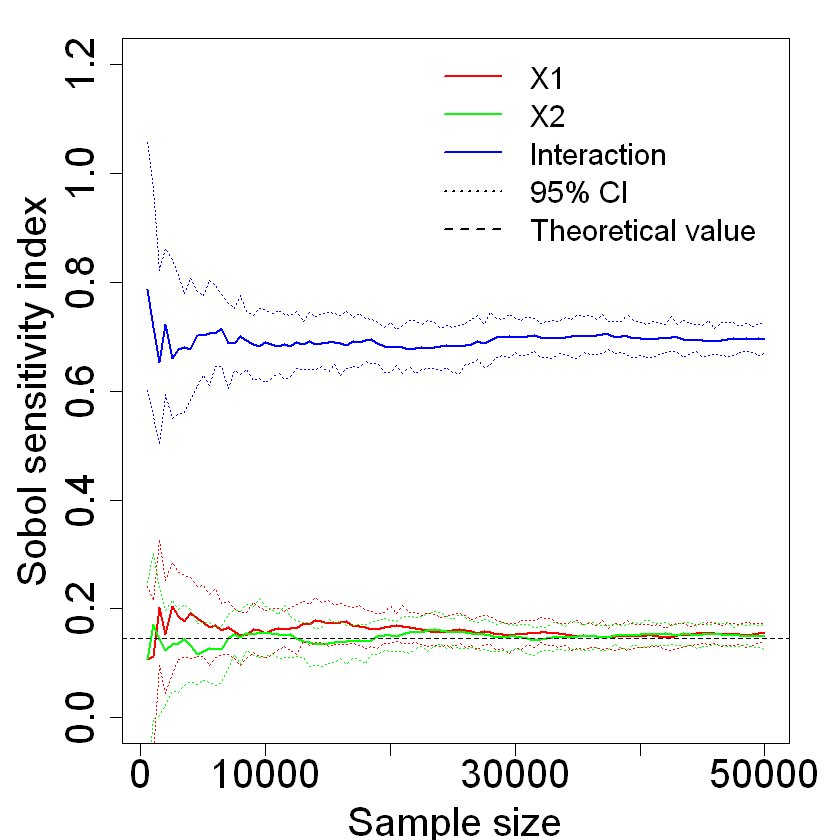

In [12]:
# Calculate Sobol sensitivity index under different base sample sizes.
# Set 100 calculations (every 1000 samples)
# S1 and S2 are first-order indices, S3 is second-order index.
S1 <- S2 <- S3 <- rep(NA,100)
S1_up <- S2_up <- S3_up <- rep(NA,100)
S1_low <- S2_low <- S3_low <- rep(NA,100)
for (i in 1:100){
  S<-sensitivity::sobol(model = Reliability, X1 = X1[1:(n/100*i), ], X2 = X2[1:(n/100*i), ],
                        order=2, nboot = 100)
  S1[i]<-S$S$original[1]
  S2[i]<-S$S$original[2]
  S3[i]<-S$S$original[3]
  S1_up[i]<-S$S$`max. c.i.`[1]
  S2_up[i]<-S$S$`max. c.i.`[2]
  S3_up[i]<-S$S$`max. c.i.`[3]
  S1_low[i]<-S$S$`min. c.i.`[1]
  S2_low[i]<-S$S$`min. c.i.`[2]
  S3_low[i]<-S$S$`min. c.i.`[3]
}
# Plot Sobol sensitivity index
par(mar=c(4,5.1,1.6,2.1))
plot(seq(n/100,n,by=n/100),S1,type="l",lwd=2,xlab="Sample size",ylab="Sobol sensitivity index",
     cex.lab=2,cex.axis=2,ylim=c(0,1.2),col="red")
lines(seq(n/100,n,by=n/100),S2,lwd=2,col="green")
lines(seq(n/100,n,by=n/100),S3,lwd=2,col="blue")
lines(seq(n/100,n,by=n/100),S1_up,lwd=1,lty=3,col="red")
lines(seq(n/100,n,by=n/100),S2_up,lwd=1,lty=3,col="green")
lines(seq(n/100,n,by=n/100),S3_up,lwd=1,lty=3,col="blue")
lines(seq(n/100,n,by=n/100),S1_low,lwd=1,lty=3,col="red")
lines(seq(n/100,n,by=n/100),S2_low,lwd=1,lty=3,col="green")
lines(seq(n/100,n,by=n/100),S3_low,lwd=1,lty=3,col="blue")
abline(h=S_theoretical,lty=2) # theoretical value of S1 and S2
legend("topright",lwd=c(2,2,2,2,2),lty=c(1,1,1,3,2),col = c("red","green","blue","black","black"),
       legend = c("X1","X2","Interaction","95% CI","Theoretical value"),cex=1.5,bty="n")

In [20]:
# Morris method 
# Morris method is one-at-a-time (OAT) deriviative based method. Each local deriviative is called
#   an elementary effect.  For example: (y(x1, x2)-y(x1+dx, x2))/dx
#
# Each "trajectory" involves (N+1) = 3 sample points (which means two elementary effects), varying
#   each input parameter once based on defined dx.
#   Total number of model runs = n*(N+1) = 3n
# A figure illustration of how this works is shown after the analysis.
set.seed(1)
s1<-rep(NA,100)
s2<-rep(NA,100)

# "factors" is the number of input parameters; "r" is the number of trajectories;
# "levels" shows how many intervals each input parameter is divided into;
# "grid.jump" is the length of dx
# Calculate Morris analysis result every 100 trajectories
# Record sigma, which can be intepreted as a first-order influence.
r<-100
for (i in 1:100){
  M <- morris(model = Reliability, factors = 2, r = r*i,
              design = list(type = "oat", levels = 1000, grid.jump = 100))
  s1[i] <- apply(M$ee, 2, sd)[1]
  s2[i] <- apply(M$ee, 2, sd)[2]
}

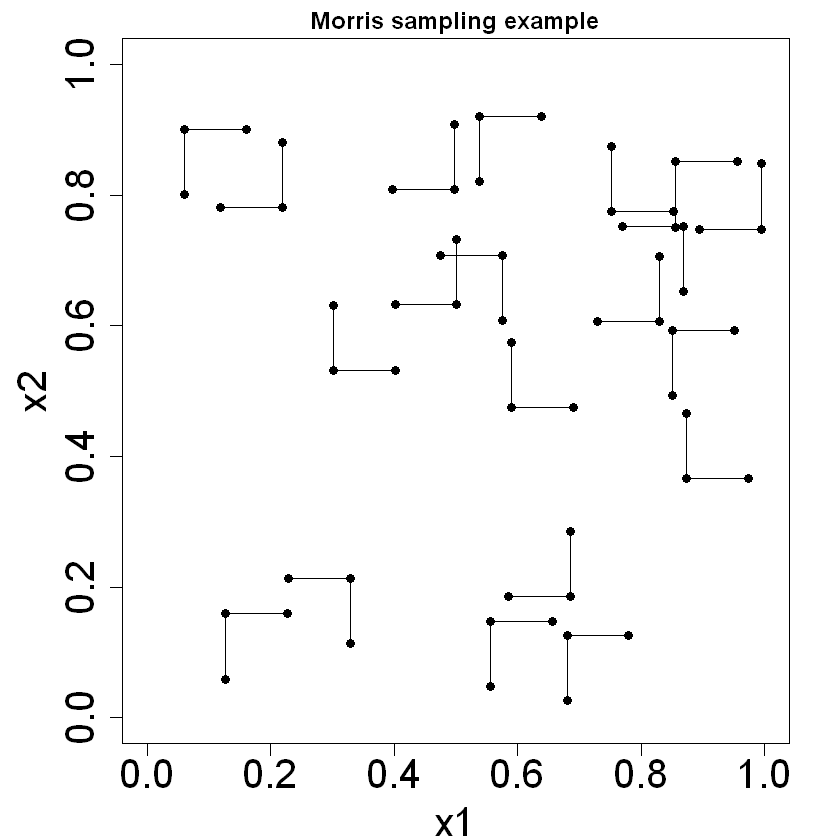

In [16]:
# Plot the first 20 sample trajectories as an example of how Morris method works.
par(mar=c(4,5.1,1.6,2.1))
plot(M$X[c(1:60),1],M$X[c(1:60),2],pch=19,cex=1,xlim=c(0,1),ylim=c(0,1),xlab="x1",ylab="x2",cex.lab=2,cex.axis=2)
# Each line represents an elementary effect
for (i in 1:20){
  lines(c(M$X[i*3-2,1],M$X[i*3-1,1]),c(M$X[i*3-2,2],M$X[i*3-1,2]))
  lines(c(M$X[i*3-1,1],M$X[i*3,1]),c(M$X[i*3-1,2],M$X[i*3,2]))
}
title(main = "Morris sampling example",cex=2)

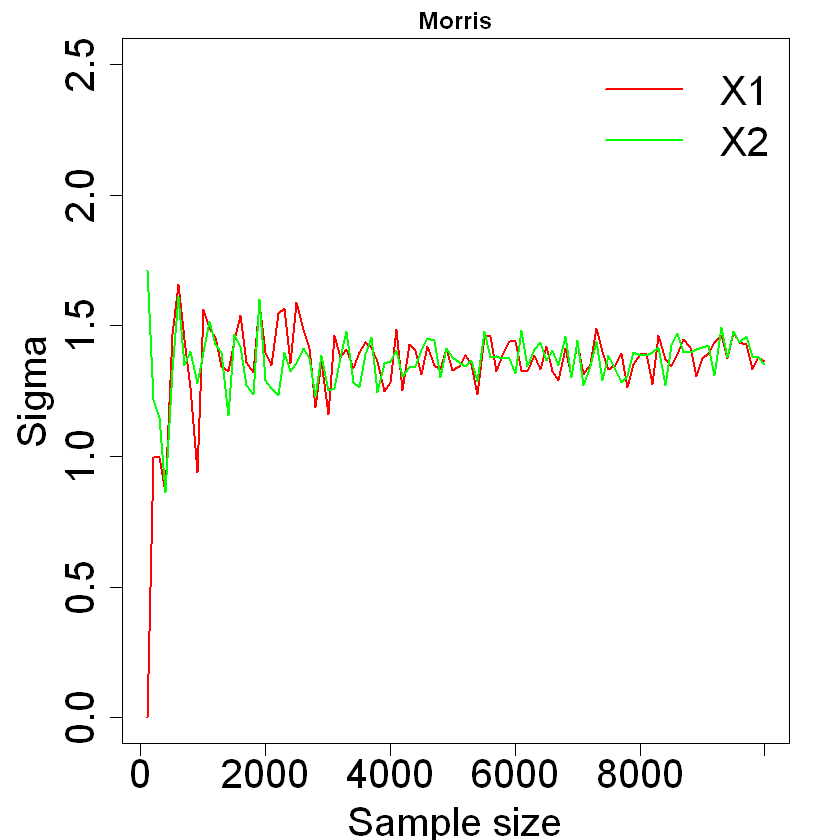

In [17]:
# Plot sensitivity index
par(mar=c(4,5.1,1.6,2.1))
plot(seq(r,r*100,by=r),s1,type="l",lwd=2,xlab="Sample size",ylab="Sigma",
     cex.lab=2,cex.axis=2,ylim=c(0,2.5),col="red")
lines(seq(r,r*100,by=r),s2,lwd=2,col="green")
legend("topright",lwd=c(2,2),col = c("red","green"),legend = c("X1","X2"),cex=2,bty="n")
title(main = "Morris",cex=2)

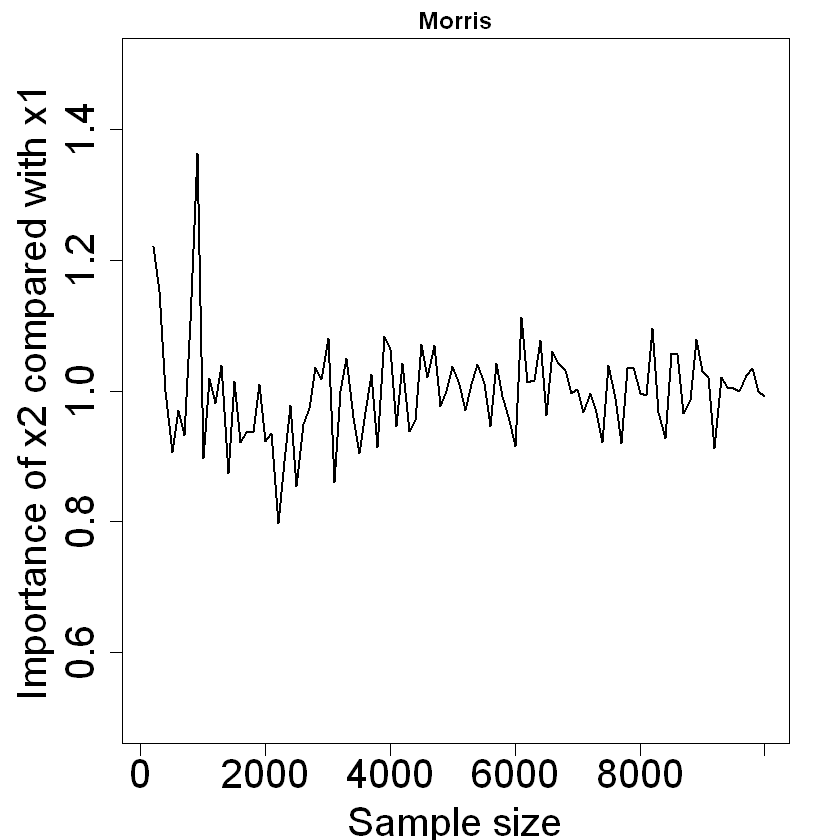

In [18]:
# To more accurately intepret the Morris method results, we should compare the importance
#   between each parameter.
par(mar=c(4,5.1,1.6,2.1))
plot(seq(r,r*100,by=r),s2/s1,type="l",lwd=2,xlab="Sample size",ylab="Importance of x2 compared with x1",
     cex.lab=2,cex.axis=2,ylim=c(0.5,1.5),col="black")
title(main = "Morris",cex=2)
# Note we don't see the same convergence as in Sobol results, but we can conclude the importances
#   of X1 and X2 are roughly the same.